In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd

In [4]:
import datetime as dt

Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# Create the inspector and connect it to the engine
inspector = inspect(engine)

In [8]:
# Collect the names of tables within the database
inspector.get_table_names()

['measurement', 'station']

In [9]:
# Using the inspector to print the column names within the 'measurement' table and its types
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [10]:
# Using the inspector to print the column names within the 'station' table and its types
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [11]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [12]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [13]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [14]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [15]:
# Display the row's columns and data in dictionary format
first_row = session.query(Measurement).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1bae945be80>,
 'prcp': 0.08,
 'station': 'USC00519397',
 'id': 1,
 'tobs': 65.0,
 'date': '2010-01-01'}

In [16]:
# Earliest Date
session.query(Measurement.date).order_by(Measurement.date).first()

('2010-01-01')

 Exploratory Climate Analysis

In [17]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database

# Latest Date
session.query(Measurement.date).order_by(Measurement.date.desc()).first()

('2017-08-23')

In [18]:
# Perform a query to retrieve the data and precipitation scores
results= session.query(Measurement.date, Measurement.prcp).\
        filter(Measurement.date > '2016-08-22').\
        order_by(Measurement.date).all()

In [44]:
# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date

df = pd.DataFrame(results, columns=['date', 'precipitation'])
df = df.sort_values('date')
df.head(10)

,date,precipitation
0,2016-08-23,0.00
1,2016-08-23,0.15
2,2016-08-23,0.05
3,2016-08-23,NaN
4,2016-08-23,0.02
5,2016-08-23,1.79
6,2016-08-23,0.70
13,2016-08-24,1.45
12,2016-08-24,2.15
11,2016-08-24,1.22


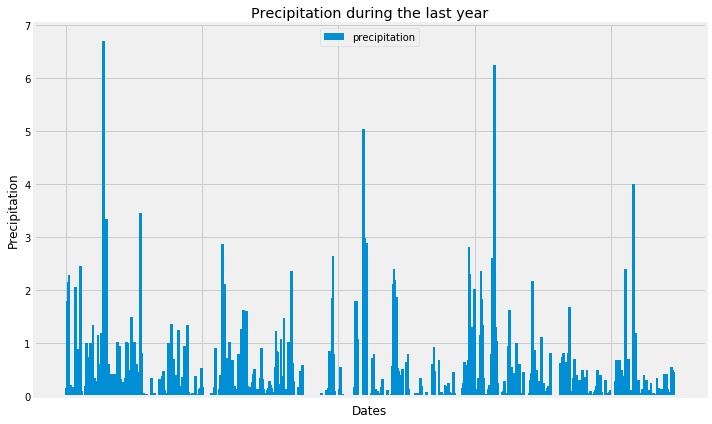

In [51]:
# Use Pandas Plotting with Matplotlib to plot the data

fig, ax = plt.subplots()
xpos = range(1, len(df['date'])+1)
ax.bar(xpos, df['precipitation'],width=10)
ax.set_xlabel("Dates")
ax.set_ylabel("Precipitation")
#ax.set_xticks(xpos)
#ax.set_xticklabels(df['date'])
#plt.xticks(rotation=90)
ax.set_title("Precipitation during the last year")
plt.legend(['precipitation'],loc='upper center')
#ax.grid(linestyle='-', linewidth='0.5', color='gray')
#ax.axes.get_xaxis().set_visible(False)
#plt.xticks([], [])
plt.grid(True)
ax.xaxis.set_ticklabels([])
fig.tight_layout()
plt.show()
fig.savefig('prcp_last_year.png')

In [21]:
# Use Pandas to calcualte the summary statistics for the precipitation data

prec = df.iloc[:, -1]
mean_prec=prec.mean()
mod_prec=prec.mode()
media_prec=prec.median()
var_prec = prec.sem()
print("The mean of precipitacion is {}".format(mean_prec))
print("The mode of precipitacion is {}".format(mod_prec))
print("The media of precipitacion is {}".format(media_prec))
print("The standard error on means of precipitacion is {}".format(var_prec))

The mean of precipitacion is 0.17727857496288896
The mode of precipitacion is 0    0.0
dtype: float64
The media of precipitacion is 0.02
The standard error on means of precipitacion is 0.010258792791451839


Station Analysis

In [22]:
# Design a query to show how many stations are available in this dataset?

session.query(Measurement.station).distinct(Measurement.station).count()

9

In [23]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

session.query(Measurement.station, func.count(Measurement.tobs)).group_by(Measurement.station).\
    order_by(func.count(Measurement.tobs).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [24]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?

session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == 'USC00519281').group_by(Measurement.station).all()

[(54.0, 85.0, 71.66378066378067)]

In [25]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

session.query(Measurement.date).filter(Measurement.station == 'USC00519281').order_by(Measurement.date.desc()).first()

('2017-08-18')

In [26]:
results_station= session.query(Measurement.date, Measurement.tobs).\
        filter(Measurement.date > '2016-08-17').\
        filter(Measurement.station == 'USC00519281').order_by(Measurement.date).all()

In [27]:
df = pd.DataFrame(results_station, columns=['date', 'temperature'])
df = df.sort_values('date')
df.head(10)

,date,temperature
0,2016-08-18,80.0
1,2016-08-19,79.0
2,2016-08-20,81.0
3,2016-08-21,79.0
4,2016-08-22,78.0
5,2016-08-23,77.0
6,2016-08-24,77.0
7,2016-08-25,80.0
8,2016-08-26,80.0
9,2016-08-27,75.0


<function matplotlib.pyplot.show(*args, **kw)>

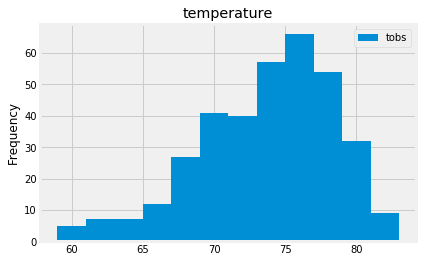

In [28]:
hist = df.hist(column='temperature', bins=12)
#plt.hist(df['temperature'], density=12, bins=12)
plt.ylabel('Frequency')
plt.legend(['tobs'],loc='upper right')
plt.show

Climate App

In [29]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [72]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

result_vacation=calc_temps('2017-07-15', '2017-08-15')
result_vacation

[(70.0, 78.81065088757397, 84.0)]

In [73]:
tvacation = list(np.ravel(result_vacation))
tvacation

[70.0, 78.81065088757397, 84.0]

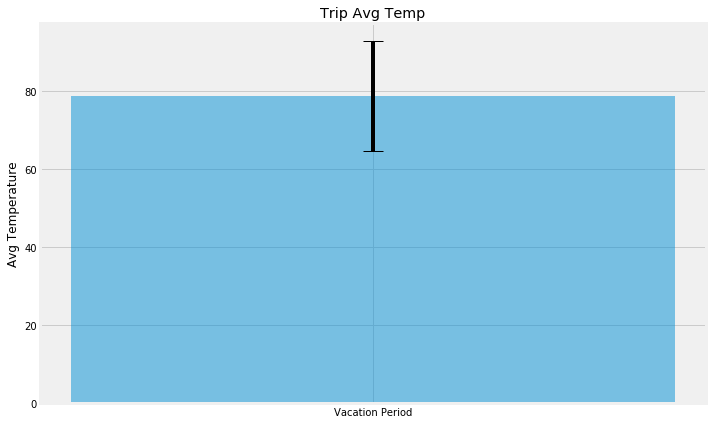

In [79]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

# Build the plot
tmean=['Vacation Period']
xpos=np.arange(len(tmean))
fig, ax = plt.subplots()
ax.bar(xpos, tvacation[1], yerr=(tvacation[2] - tvacation[0]), align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Avg Temperature')
ax.set_xticks(xpos)
ax.set_xticklabels(tmean)
ax.set_title('Trip Avg Temp')
ax.yaxis.grid(True)

# Save the figure and show
plt.tight_layout()
plt.savefig('bar_plot_with_error_bars.png')
plt.show()

In [87]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

sel = [Measurement.station, Station.name, Station.latitude, Station.longitude, Station.elevation, Measurement.prcp]
same_station = session.query(*sel).filter(Measurement.station == Station.station).\
filter(Measurement.date >= '2017-07-15').filter(Measurement.date <= '2017-08-15').\
order_by(Measurement.prcp.desc()).all()
same_station

[('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  4.0),
 ('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  2.4),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0,
  1.19),
 ('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  0.84),
 ('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  0.8),
 ('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  0.7),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  0.61),
 ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.58),
 ('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  0.5),
 ('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  0.42),
 ('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
 